# Explore the effect of overlap size in slicing embeddings for different predictions on the STBM scenarios

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import pandas as pd
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback
from tqdm import tqdm_notebook

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
random.seed(1)
np.random.seed(1)

## Drawing the predictions

In [3]:
def plot_ξ_kde(glk, q_pred_ξ_sample, ix_iy, palette, ax):
    g, l, k = glk
    ix, iy = ix_iy
    
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, ix].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, iy].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax)
    ax.set_title(r'$\xi_{{{ix}}} \sim \xi_{{{iy}}}$ density'.format(ix=ix, iy=iy))

def plot_ξ_μ(q_pred_μ, ix_iy, communities, palette, ax):
    ix, iy = ix_iy
    
    ax.scatter(q_pred_μ[:, ix], q_pred_μ[:, iy], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ[:, [ix, iy]]):
        ax.text(x, y, str(i), ha='center', va='center', color='white')
    ax.set_title(r'$\mu_{{{ix}}} \sim \mu_{{{iy}}}$'.format(ix=ix, iy=iy))

In [4]:
def plot_ξ_distribution(glk, q_model, q_codecs, adj, features):
    assert len(q_codecs) == 1
    q_codec = q_codecs[0]
    
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)

    q_pred = q_model.predict_fullbatch(adj=adj, features=features)
    q_pred_ξ_sample = K.eval(codecs.get_nocache(q_codec, q_pred).stochastic_value(100))
    dim_ξ = q_pred_ξ_sample.shape[-1]
    assert dim_ξ >= 2
    q_pred_μ = q_pred[:, :dim_ξ]
    
    fig, axes = plt.subplots(dim_ξ - 1, dim_ξ - 1, figsize=(4 * (dim_ξ - 1), 4 * (dim_ξ - 1)), sharex=True, sharey=True)

    for ix in range(dim_ξ - 1):
        for iy in range(ix):
            axes[ix, iy].set_visible(False)
        for iy in range(ix + 1, dim_ξ):
            ax = axes[ix, iy - 1]
            
            # KDE plot
            plot_ξ_kde(glk, q_pred_ξ_sample, (ix, iy), palette, ax)
            
            ## Inset μ plot
            #inset = inset_axes(ax, width="40%", height="40%", loc=4)
            #inset.tick_params(labelleft=False, labelbottom=False)
            #plot_ξ_μ(q_pred_μ, (ix, iy), communities, palette, inset)
            #
            ## Box representing the μ plots in the KDE plots
            #ax.hlines(inset.get_ylim(), *inset.get_xlim(), colors='lightgrey')
            #ax.vlines(inset.get_xlim(), *inset.get_ylim(), colors='lightgrey')

In [66]:
def plot_predictions(model, adj, features):
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_μ_mean = v_pred[:, :, :features.shape[1]].mean(axis=1)
    v_pred_S_mean = np.exp(v_pred[:, :, features.shape[1]:]).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5 * n_nodes / 25))

    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(features)
    ax2.set_title('Features ( = noisy labels)')
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(v_pred_μ_mean)
    im3.set_norm(im1.norm)
    ax3.set_title('Predicted labels μ')
    plt.colorbar(im3, ax=ax3)
    
    im4 = ax4.imshow(v_pred_S_mean)
    #im4.set_norm(im1.norm)
    ax4.set_title('Predicted labels S')
    plt.colorbar(im4, ax=ax4)
    
    im5 = ax5.imshow(np.random.normal(loc=v_pred_μ_mean, scale=v_pred_S_mean))
    im5.set_norm(im1.norm)
    ax5.set_title('Sampled predicted labels')
    plt.colorbar(im5, ax=ax5)

## Load the data

In [6]:
def convert_stbm_to_nw2vec(npz):
    # Load the data and recover shape variables
    Y, A, Z, W = npz['Y'], npz['A'], npz['Z'], npz['W']
    n_nodes, n_clusters = Y.shape
    n_documents, n_slots = W.shape[-2:]
    n_topics = int(Z[np.isfinite(Z)].max()) + 1
    vocabulary_size = int(W[np.isfinite(W)].max()) + 1

    # Create the graph structure
    g = nx.from_numpy_array(A, create_using=nx.DiGraph())

    # Characterise each node by the proportion of topics it emits
    labels = np.zeros((n_nodes, n_topics))
    edges = np.array(g.edges)
    edges_Z = Z[list(edges.T)].astype(np.int)
    for i, edge in enumerate(edges_Z.reshape((len(edges), -1))):
        labels[edges[i][0]] += np.bincount(edge, minlength=n_topics)
    labels /= labels.sum(1)[:, np.newaxis]

    # Make A and g symmetric
    A_sym = np.minimum(A + A.T, np.ones_like(A))
    g_sym = nx.from_numpy_array(A_sym)
    del A, g
    
    return g_sym, A_sym, labels

In [7]:
g1, A1, labels1 = convert_stbm_to_nw2vec(np.load('stbm-S1.npz'))
g2, A2, labels2 = convert_stbm_to_nw2vec(np.load('stbm-S2.npz'))
g3, A3, labels3 = convert_stbm_to_nw2vec(np.load('stbm-S3.npz'))

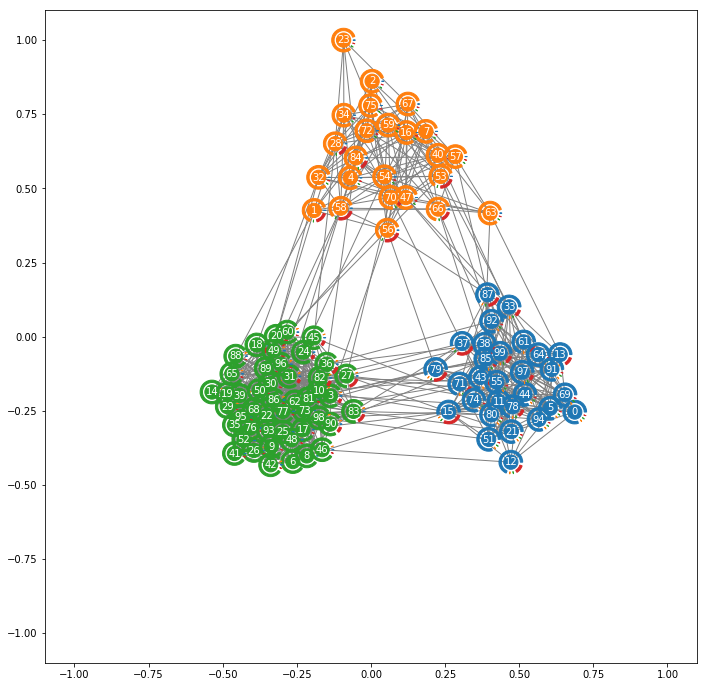

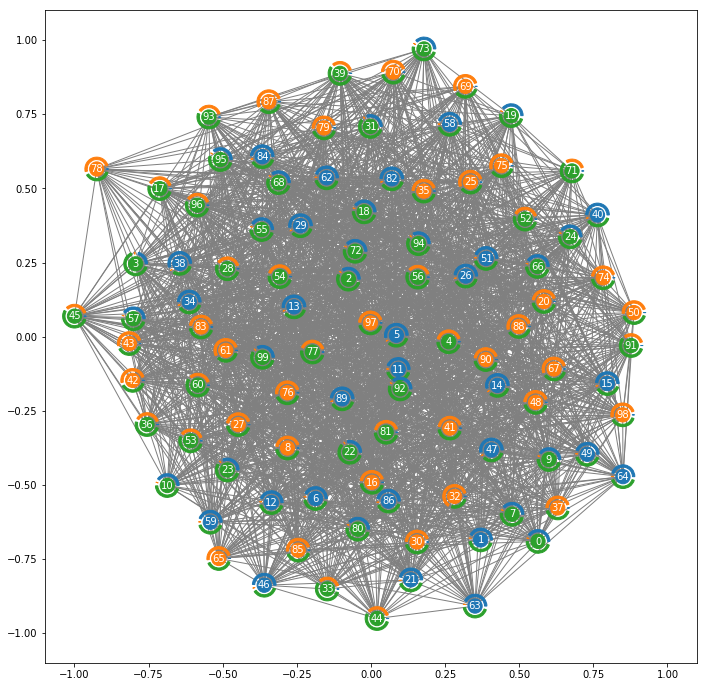

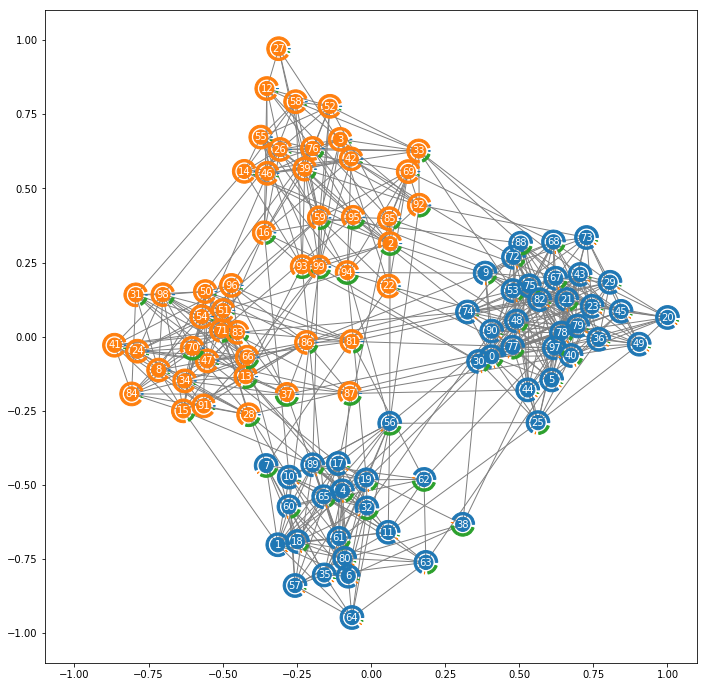

In [9]:
viz.draw_network(g1, labels=labels1)
viz.draw_network(g2, labels=labels2)
viz.draw_network(g3, labels=labels3);

## Build the VAEs

In [12]:
g, A, labels = g1, A1, labels1

In [68]:
# VAE Parameters
n_nodes = len(g.nodes)
adj = sp.sparse.csr_matrix(A).astype(np.float32)

n_ξ_samples = 5

def vaes(dim_ξ_slices):
    for overlap in range(dim_ξ_slices + 1):
        dim_data, dim_l1, dim_ξ = labels.shape[1], 10, (2 * dim_ξ_slices)  # `overlap` dimensions in the embedding are ignored
        dims = (dim_data, dim_l1, dim_ξ)

        # Actual VAE
        q_model, q_codecs = ae.build_q(dims, fullbatcher=batching.fullbatches, minibatcher=batching.pq_batches)
        p_builder = ae.build_p_builder(dims,
                                       feature_codec='OrthogonalGaussian',
                                       embedding_slices=[slice(dim_ξ_slices),
                                                         slice(dim_ξ_slices - overlap, 2 * dim_ξ_slices - overlap)],
                                       share_l1=True)
        vae, vae_codecs = ae.build_vae(
            (q_model, q_codecs), p_builder,
            n_ξ_samples,
            loss_weights=[1, 1, 10]
        )
        yield vae, q_model, q_codecs

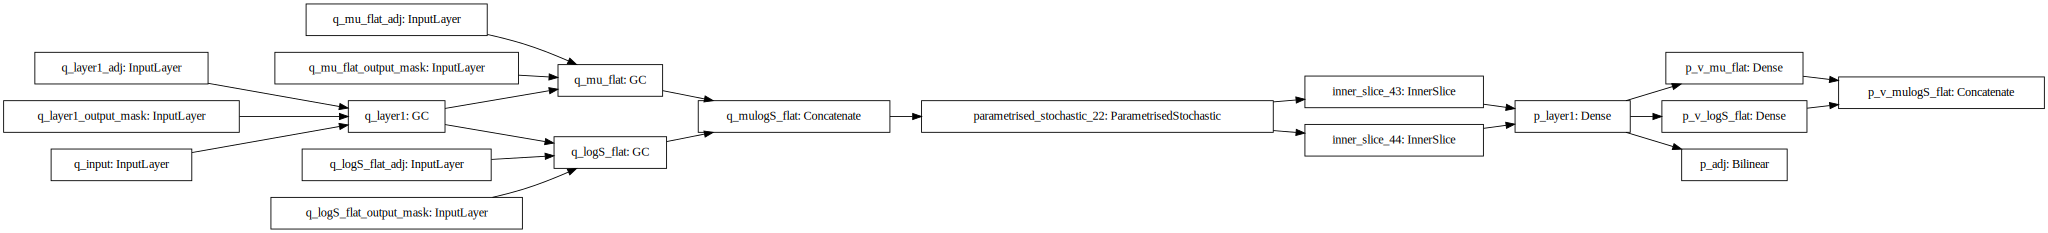

In [69]:
display(SVG(model_to_dot(next(vaes(5))[0], rankdir='LR').create(prog='dot', format='svg')))

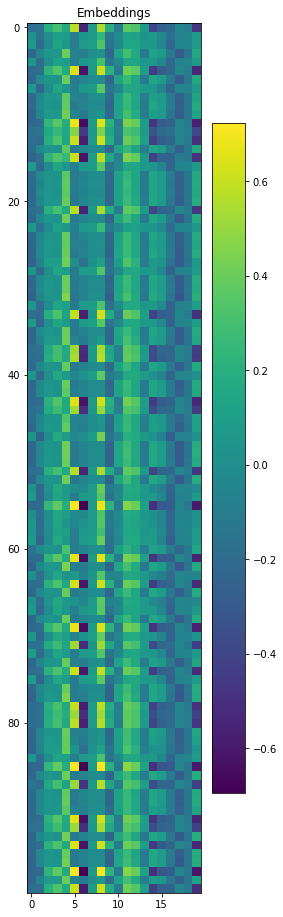

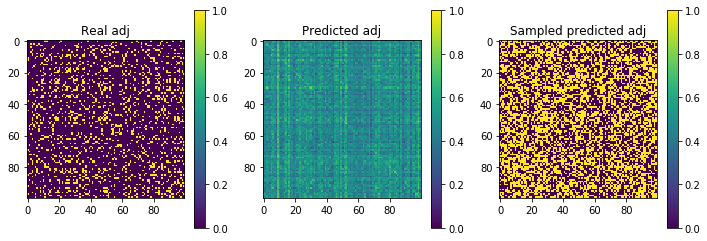

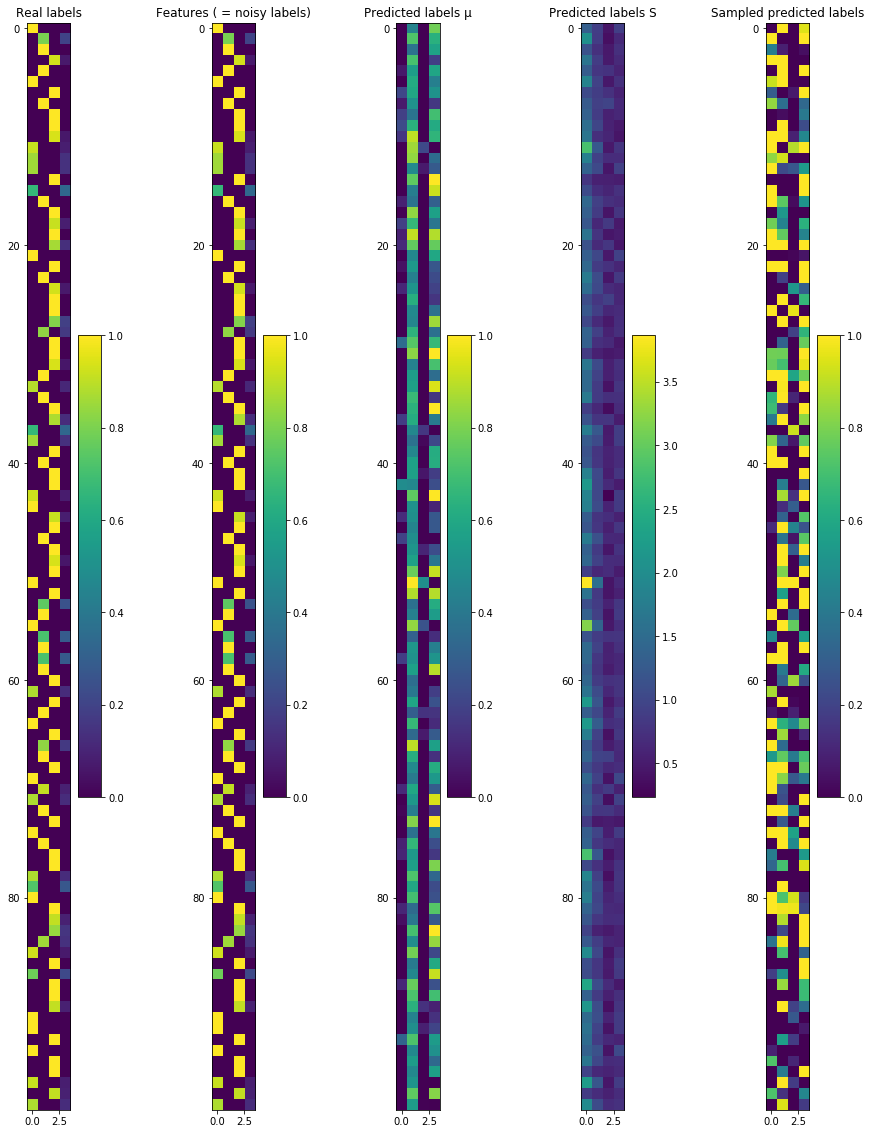

In [70]:
plot_predictions(next(vaes(5))[0], adj, labels)

## Train

In [71]:
n_epochs = 5000

# Training targets
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
    ]

### Fullbatch

In [72]:
vae_samples = 1
histories = []
trained_vaes = []

for sampling in tqdm_notebook(range(vae_samples)):
    for i, (vae, q_model, q_codec) in tqdm_notebook(enumerate(vaes(5)), total=5 + 1):
        history = vae.fit_fullbatches(batcher_kws={'adj': adj, 'features': labels, 'target_func': target_func},
                                      epochs=n_epochs,
                                      verbose=0,
                                      callbacks=[
                                          TQDMCallback(show_inner=False),
                                          keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001,
                                                                        patience=200, verbose=0,
                                                                        mode='min')
                                      ])
        if len(histories) <= i:
            histories.append([])
        histories[i].append(history)
        if len(trained_vaes) <= i:
            trained_vaes.append([])
        trained_vaes[i].append([vae, q_model, q_codec])

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loss ~ overlap

In [73]:
results = defaultdict(list)
for overlap, overlap_samples in enumerate(histories):
    for history in overlap_samples:
        for title, values in history.history.items():
            results['loss'].append(title)
            results['final avg'].append(np.mean(values[-200:]))
            results['overlap'].append(overlap)
            results['last epoch'].append(len(values))
results = pd.DataFrame(results)

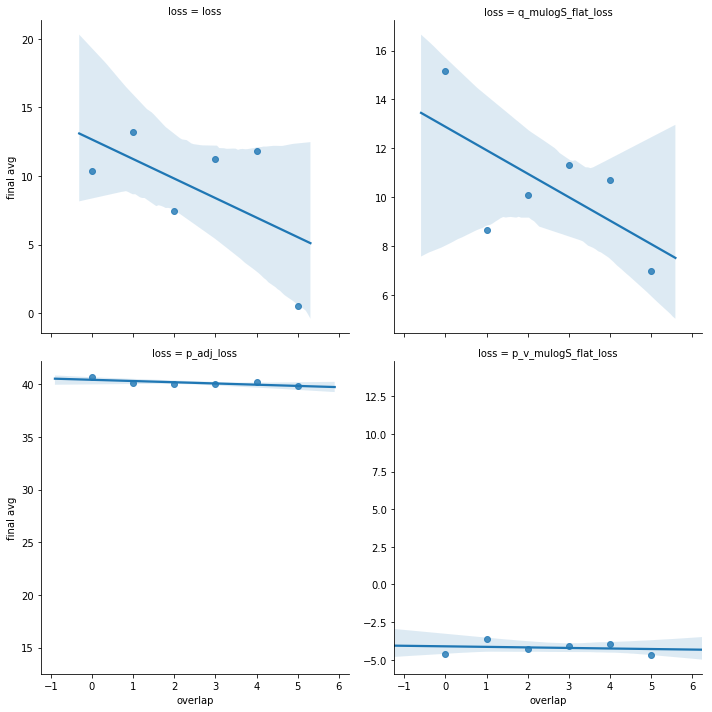

In [75]:
facet_grid = sb.lmplot(x='overlap', y='final avg', col='loss', col_wrap=2, data=results, sharey=False)
#facet_grid.axes[0].set(ylim=(45, 50))
#facet_grid.axes[1].set(ylim=(2, 7))
#facet_grid.axes[2].set(ylim=(35, 40))
#facet_grid.axes[3].set(ylim=(.2, .6));

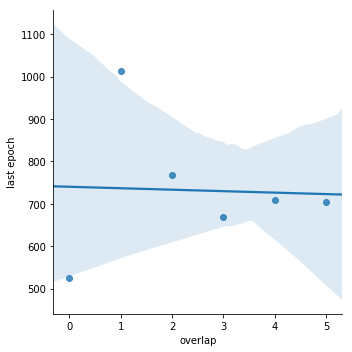

In [76]:
sb.lmplot(x='overlap', y='last epoch', data=results[results['loss'] == 'loss'])

## Results of a VAE

In [81]:
vae = trained_vaes[-1][0][0]

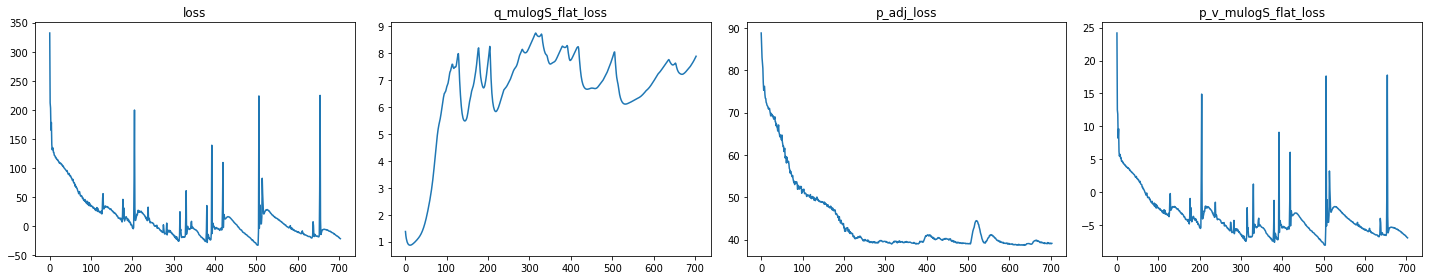

In [82]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

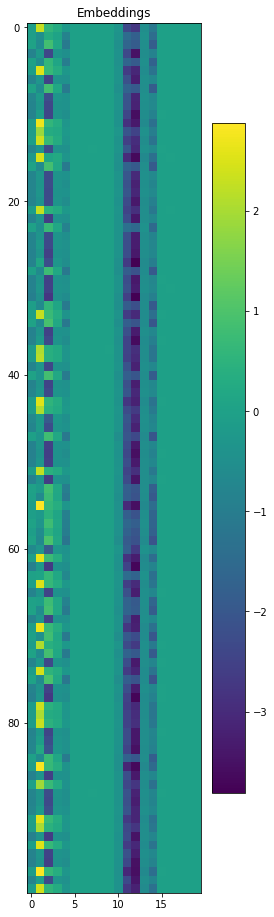

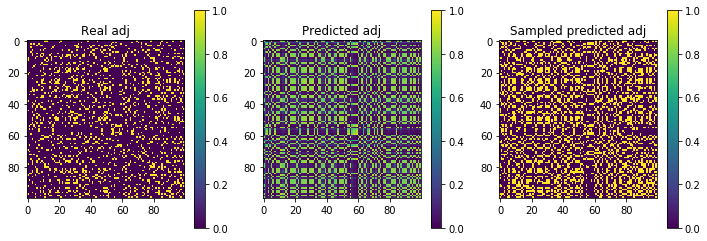

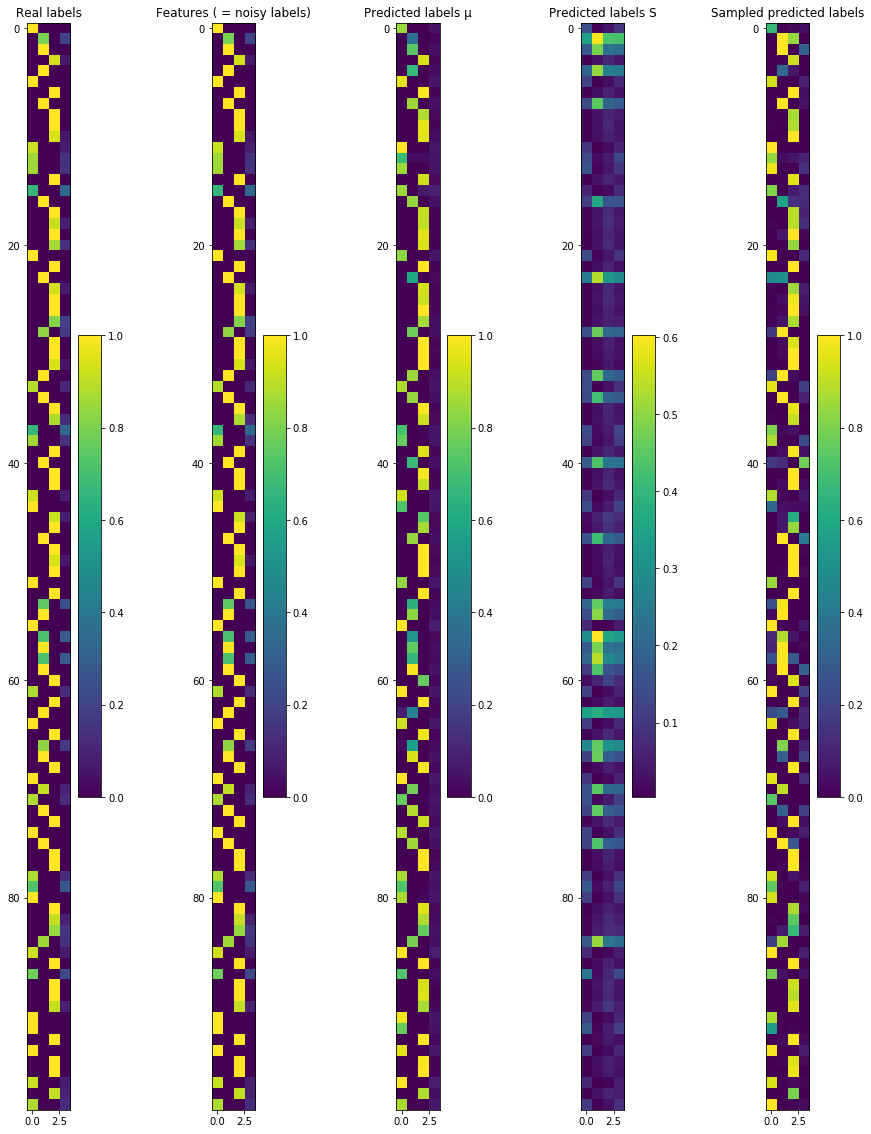

In [83]:
plot_predictions(vae, adj, labels)

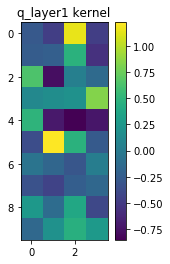

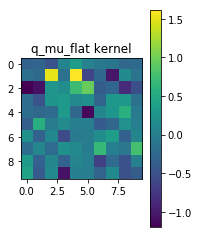

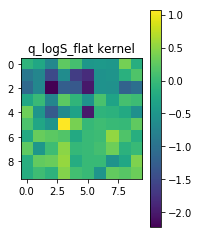

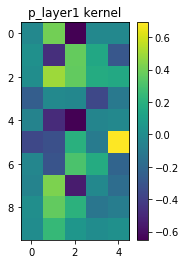

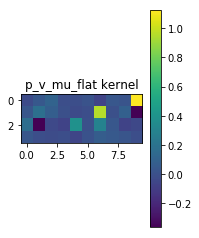

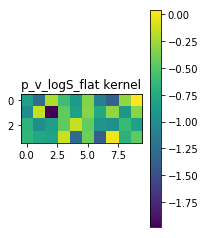

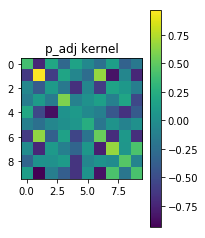

In [84]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
        if hasattr(layer, 'bias') and layer.bias is not None:
            im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
            ax2.set_title('{} bias'.format(layer.name))
            plt.colorbar(im2, ax=ax2)
        else:
            ax2.set_visible(False)